In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

gym.logger.set_level(40)

env = gym.make('LunarLander-v2').unwrapped
env.seed(0)
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):

    def __init__(self, h, w):
        super(DQN, self).__init__()  
        self.layer1 = nn.Sequential(nn.Conv2d(3, 16, 4), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.layer2 = nn.Sequential(nn.Conv2d(16, 32, 4), nn.ReLU(), nn.MaxPool2d(kernel_size=2)) 
        self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(4480, 500) 
        self.fc2 = nn.Linear(500, 4)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

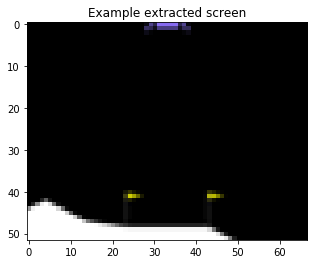

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(65, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_lander_location(screen, last_X, last_Y):    
    R = screen[0]
    G = screen[1]
    B = screen[2]
    line = 0
    coоrdinates = [[],[]]
    for line_r, line_g, line_b in zip(R, G, B):
        line += 1
        column = 0
        for pixel_r, pixel_g, pixel_b in zip(line_r, line_g, line_b):
            column +=1
            if  (round(pixel_r.item(),1) == 0.5) & (round(pixel_g.item(),1) == 0.4) & (round(pixel_b.item(),1) == 0.9):
                coоrdinates[0].append(line)
                coоrdinates[1].append(column)
    if(len(coоrdinates)>0):
        if(not np.isnan(np.array(coоrdinates[0]).mean())):
            Y = int(np.array(coоrdinates[0]).mean())
            X = int(np.array(coоrdinates[1]).mean())
            out_of_screen = False
        else:
            X = last_X
            Y = last_Y
            out_of_screen = True
    else:
        X = last_X
        Y = last_Y
        out_of_screen = True
    return (X, Y, out_of_screen)

def get_screen(last_X, last_Y):
    
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    # Resize, and add a batch dimension (BCHW) 
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    screen = resize(screen)
    
    _, screen_height, screen_width = screen.shape
    screen = screen[:, :int(screen_height * 0.8)]
    _, screen_height, screen_width = screen.shape
    slice_width = slice(15,screen_width-15)
    screen = screen[:, :, slice_width]
    
    X, Y , out_of_screen = get_lander_location(screen, last_X, last_Y)
    
    return (screen.unsqueeze(0), X, Y, out_of_screen)


env.reset()

screen, last_X, last_Y, out_of_screen= get_screen(0, 0)
plt.figure()
plt.imshow(screen.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [6]:
BATCH_SIZE = 32
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 1

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen, last_X, last_Y, _ = get_screen(last_X, last_Y)
_, _, screen_height, screen_width = init_screen.shape

policy_net = DQN(screen_height, screen_width).to(device)
target_net = DQN(screen_height, screen_width).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(4)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    buff = []
    for i in batch.reward:
        buff.append(i.float())
    reward_batch = torch.FloatTensor(buff)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [8]:
def get_distance(X, X_zero, Y, Y_zero):
    dist = math.sqrt((X-X_zero)**2+(Y-Y_zero)**2)
    return dist
def get_distance2(X, X_zero):
    dist = math.sqrt((X-X_zero)**2)
    return dist

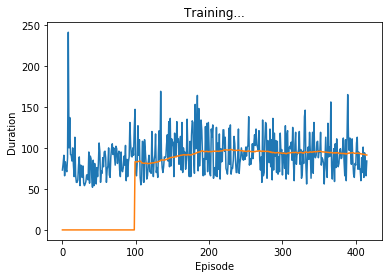

9
reward: -211.3368024977218
reward mean: -217.03378706587574
max reward: -55.80911104334898
time for episode: 17.2 sec
remained: 0.54 min
passed: 2.69 min
Complete


<Figure size 432x288 with 0 Axes>

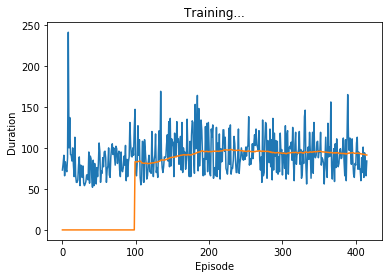

In [12]:
num_episodes = 10
passed = 0
plt.figure()
reward_sum = 0
rew_max = -999999
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen, last_X, last_Y, out_of_screen = get_screen(last_X, last_Y)
    current_screen, current_X, current_Y, out_of_screen = get_screen(last_X, last_Y)
    
    state = current_screen - last_screen
    
    done = False
    reward = 0
    rew_per_episode = 0
    start_time = time.time()
    
    dist_to_finish = get_distance(current_X, 15, current_Y, 47)
    
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, env_reward, done, _ = env.step(action.item())
        
        rew_per_episode += env_reward
        if env_reward > 10:
            reward = 0.1*env_reward
        prev_dist_to_finish = dist_to_finish
        speed = get_distance(current_X, last_X, current_Y, last_Y)
        dist_to_finish = get_distance(current_X, 25, current_Y, 47)
        dist_X = get_distance2(current_X, 25)
        dist_Y = get_distance2(current_Y, 47)
        # Observe new state
        last_screen = current_screen
        last_X, last_Y = current_X, current_Y
        current_screen, current_X, current_Y, out_of_screen = get_screen(last_X, last_Y)
        
        if(out_of_screen):
            reward-=1
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        
        if(dist_Y<7):
            reward += 1/(speed+0.1)
        if(dist_X<15):
            reward += 5/(dist_X+0.1)
        else:
            reward -= 5/(dist_X+0.1)
        if(dist_Y<15):
            reward += 5/(dist_Y+0.1)
        else:
            reward -= 5/(dist_Y+0.1)
        # Store the transition in memory
        reward = torch.FloatTensor([reward], device=device)
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    target_net.load_state_dict(policy_net.state_dict())
    end_time = time.time()
    time_result = end_time-start_time
    passed += time_result
    reward_sum += rew_per_episode
    if(rew_max<rew_per_episode):
        rew_max = rew_per_episode
    print(i_episode)
    print("reward: " + str(rew_per_episode))
    print("reward mean: " + str(reward_sum/(i_episode+1)))
    print("max reward: " + str(rew_max))
    print("time for episode: " + str(round(time_result,2)) + " sec")
    print("remained: " + str(round(((num_episodes-i_episode+1)*(passed/(i_episode+1)/60)),2)) + " min")
    print("passed: " + str(round(passed/60,2)) + " min")
    
print('Complete')
env.render()
env.close()
plt.figure
plt.show()

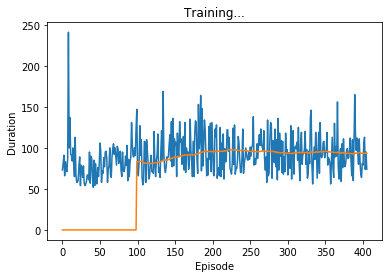

5
reward: -432.2856592664995
reward mean: -489.69822293795306
max reward: -100
time for episode: 5.72
remained: 11.31
passed: 0.71


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

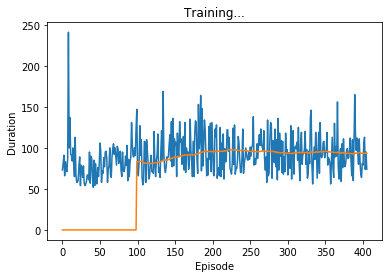

In [11]:
num_episodes = 100
passed = 0
plt.figure()
reward_sum = 0
rew_max = -999999
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen, last_X, last_Y, out_of_screen = get_screen(last_X, last_Y)
    current_screen, current_X, current_Y, out_of_screen = get_screen(last_X, last_Y)
    
    state = current_screen - last_screen
    
    done = False
    reward = 0
    rew_per_episode = 0
    start_time = time.time()
    
    dist_to_finish = get_distance(current_X, 15, current_Y, 47)
    
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, rewards, done, _ = env.step(action.item())
        rew_per_episode += rewards
        prev_dist_to_finish = dist_to_finish
        speed = get_distance(current_X, last_X, current_Y, last_Y)
        dist_to_finish = get_distance(current_X, 25, current_Y, 47)
        dist_X = get_distance2(current_X, 25)
        dist_Y = get_distance2(current_Y, 47)
        # Observe new state
        last_screen = current_screen
        last_X, last_Y = current_X, current_Y
        current_screen, current_X, current_Y, out_of_screen = get_screen(last_X, last_Y)
        reward += rewards*0.1
        if(out_of_screen):
            reward-=1
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        
        if(dist_Y<15):
            reward += 5/(speed+0.1)
        if(dist_X<15):
            reward += 5/(dist_X+0.1)
        else:
            reward -= 5/(dist_X+0.1)
        if(dist_Y<15):
            reward += 5/(dist_Y+0.1)
        else:
            reward -= 5/(dist_Y+0.1)
        # Store the transition in memory
        reward = torch.FloatTensor([reward], device=device)
        memory.push(state, action, next_state, reward)
        
        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization (on the target network)
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    end_time = time.time()
    time_result = end_time-start_time
    passed += time_result
    reward_sum += rew_per_episode
    if(rew_max<rew_per_episode):
        rew_max = rewards
    print(i_episode)
    print("reward: " + str(rew_per_episode))
    print("reward mean: " + str(reward_sum/(i_episode+1)))
    print("max reward: " + str(rew_max))
    print("time for episode: " + str(round(time_result,2)))
    print("remained: " + str(round(((num_episodes-i_episode+1)*(passed/(i_episode+1)/60)),2)))
    print("passed: " + str(round(passed/60,2)))
    
print('Complete')
env.render()
env.close()
plt.figure
plt.show()

In [ ]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)